# Import

In [1]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cosine
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import lightgbm as lgb
import bisect
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

# Data Load

In [2]:
# Train Data와 Test Data를 불러온다고 가정합니다.
train = pd.read_csv('../open/train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv('../open/test.csv').drop(columns=['SAMPLE_ID'])

# Data Preprocessing

In [3]:
# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)

# Categorical 컬럼 인코딩
categorical_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

# 결측치 처리
train.fillna(train.mean(), inplace=True)
test.fillna(train.mean(), inplace=True)

Encoding features: 100%|█████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.43it/s]


# Validation

In [4]:
# 수치형 특성만 선택합니다.
numeric_features = test.select_dtypes(include=['int', 'float']).columns  # 수치형 특성의 컬럼 이름을 지정해야 합니다.

In [5]:
# Test Data에서 수치형 특성의 평균과 표준편차를 계산합니다.
test_mean = test[numeric_features].mean()
test_std = test[numeric_features].std()

In [6]:
# Train Data에서 각 샘플과 Test Data 간의 코사인 유사도를 계산합니다.
train['cosine_similarity'] = train[numeric_features].apply(
    lambda x: 1 - cosine(x, test_mean / test_std), axis=1
)

In [7]:
sample_size = int(train.shape[0]*0.2)
sample_size

73488

In [8]:
# 유사성이 높은 상위 샘플을 선택합니다.
top_samples = train.sort_values(by='cosine_similarity', ascending=False).head(sample_size)
top_samples_index = top_samples.index

In [9]:
top_samples

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,...,BDI_ADJ,PORT_SIZE,CI_HOUR,year,month,day,hour,minute,weekday,cosine_similarity
21585,17,21,3,24.543665,1152,10.0,18,600,0.0,0.0,...,808.306999,0.002615,30.985000,2022,8,28,23,21,6,0.782302
78002,17,21,3,15.325364,1152,10.0,18,600,0.0,0.0,...,892.555320,0.002615,13.594167,2022,8,24,12,22,2,0.774234
220697,8,66,1,0.000000,135,10.0,5,1470,10.0,0.0,...,738.827209,0.000552,0.000000,2023,1,13,23,31,4,0.761237
151895,8,83,3,7.381604,1206,10.0,5,570,0.0,0.0,...,964.086913,0.000030,106.489444,2022,8,20,11,58,5,0.756536
26938,8,83,3,6.952462,1206,10.0,5,570,0.0,0.0,...,1102.381325,0.000030,189.510833,2022,8,9,1,25,1,0.742391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282737,16,18,1,10.033131,21044,20.0,12,6550,10.0,10.0,...,1021.891305,0.000399,20.913889,2022,11,14,10,56,0,0.090819
214143,17,21,3,8.267217,21123,20.0,10,6980,10.0,10.0,...,1955.103846,0.002615,77.985000,2022,4,23,6,57,5,0.090819
297092,4,13,2,0.000000,17271,20.0,19,11200,10.0,10.0,...,882.531444,0.001660,0.000000,2023,1,6,13,35,4,0.090818
249801,8,66,2,0.000000,3495,20.0,26,17200,10.0,10.0,...,1400.113336,0.000552,0.000000,2017,9,21,22,42,3,0.090817


In [10]:
top_samples_index

Index([ 21585,  78002, 220697, 151895,  26938,  85170,  28846, 142253, 270976,
       225779,
       ...
       230569, 351707,  23871, 279024, 213338, 282737, 214143, 297092, 249801,
       260643],
      dtype='int64', length=73488)

In [11]:
val_df = top_samples.reset_index(drop=True)
train = train.drop(top_samples_index).reset_index(drop=True)

In [12]:
val_df.drop(['cosine_similarity'],axis=1,inplace=True)

In [13]:
print(val_df.shape)
display(val_df)

(73488, 31)


,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,...,WTI,BDI_ADJ,PORT_SIZE,CI_HOUR,year,month,day,hour,minute,weekday
0,17,21,3,24.543665,1152,10.0,18,600,0.0,0.0,...,91.64,808.306999,0.002615,30.985000,2022,8,28,23,21,6
1,17,21,3,15.325364,1152,10.0,18,600,0.0,0.0,...,92.52,892.555320,0.002615,13.594167,2022,8,24,12,22,2
2,8,66,1,0.000000,135,10.0,5,1470,10.0,0.0,...,79.86,738.827209,0.000552,0.000000,2023,1,13,23,31,4
3,8,83,3,7.381604,1206,10.0,5,570,0.0,0.0,...,94.89,964.086913,0.000030,106.489444,2022,8,20,11,58,5
4,8,83,3,6.952462,1206,10.0,5,570,0.0,0.0,...,86.53,1102.381325,0.000030,189.510833,2022,8,9,1,25,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73483,16,18,1,10.033131,21044,20.0,12,6550,10.0,10.0,...,86.92,1021.891305,0.000399,20.913889,2022,11,14,10,56,0
73484,17,21,3,8.267217,21123,20.0,10,6980,10.0,10.0,...,101.70,1955.103846,0.002615,77.985000,2022,4,23,6,57,5
73485,4,13,2,0.000000,17271,20.0,19,11200,10.0,10.0,...,73.77,882.531444,0.001660,0.000000,2023,1,6,13,35,4
73486,8,66,2,0.000000,3495,20.0,26,17200,10.0,10.0,...,50.55,1400.113336,0.000552,0.000000,2017,9,21,22,42,3


In [14]:
train.drop(['cosine_similarity'],axis=1,inplace=True)

In [15]:
print(train.shape)
display(train)

(293953, 31)


,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,...,WTI,BDI_ADJ,PORT_SIZE,CI_HOUR,year,month,day,hour,minute,weekday
0,4,13,0,30.736578,24337,30.0,28,73100,20.0,10.0,...,40.96,1407.668330,0.001660,3.048333,2020,10,15,4,3,3
1,4,14,2,63.220425,19552,30.0,15,37900,20.0,10.0,...,59.34,2089.046774,0.001614,17.138611,2019,9,17,2,55,1
2,4,45,2,90.427421,20449,50.0,7,115000,20.0,10.0,...,56.94,603.193047,0.001743,98.827500,2019,2,23,6,43,5
3,16,46,2,8.813725,2989,30.0,10,27600,10.0,10.0,...,88.11,1107.944894,0.000197,96.030556,2022,8,13,12,57,5
4,4,45,2,81.435335,23924,30.0,22,18100,10.0,10.0,...,45.92,820.288044,0.001743,42.078056,2015,9,8,14,24,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293948,4,62,0,55.408765,3037,30.0,16,26500,10.0,10.0,...,109.56,2067.433444,0.000595,83.960833,2022,6,16,14,27,3
293949,0,37,0,0.000000,21121,40.0,11,87300,20.0,10.0,...,77.40,1404.453239,0.000058,0.000000,2014,11,10,23,4,0
293950,4,100,0,59.018184,9173,40.0,13,93200,20.0,10.0,...,55.70,1333.609109,0.000360,65.850000,2017,11,11,22,23,5
293951,17,21,2,1.768630,15882,30.0,6,25000,20.0,10.0,...,95.78,1601.291086,0.002615,0.997500,2022,7,14,7,58,3


# 모델 학습 및 특성 중요도 확인

Model Tune for LGBM.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3915
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 30
[LightGBM] [Info] Start training from score 63.371721


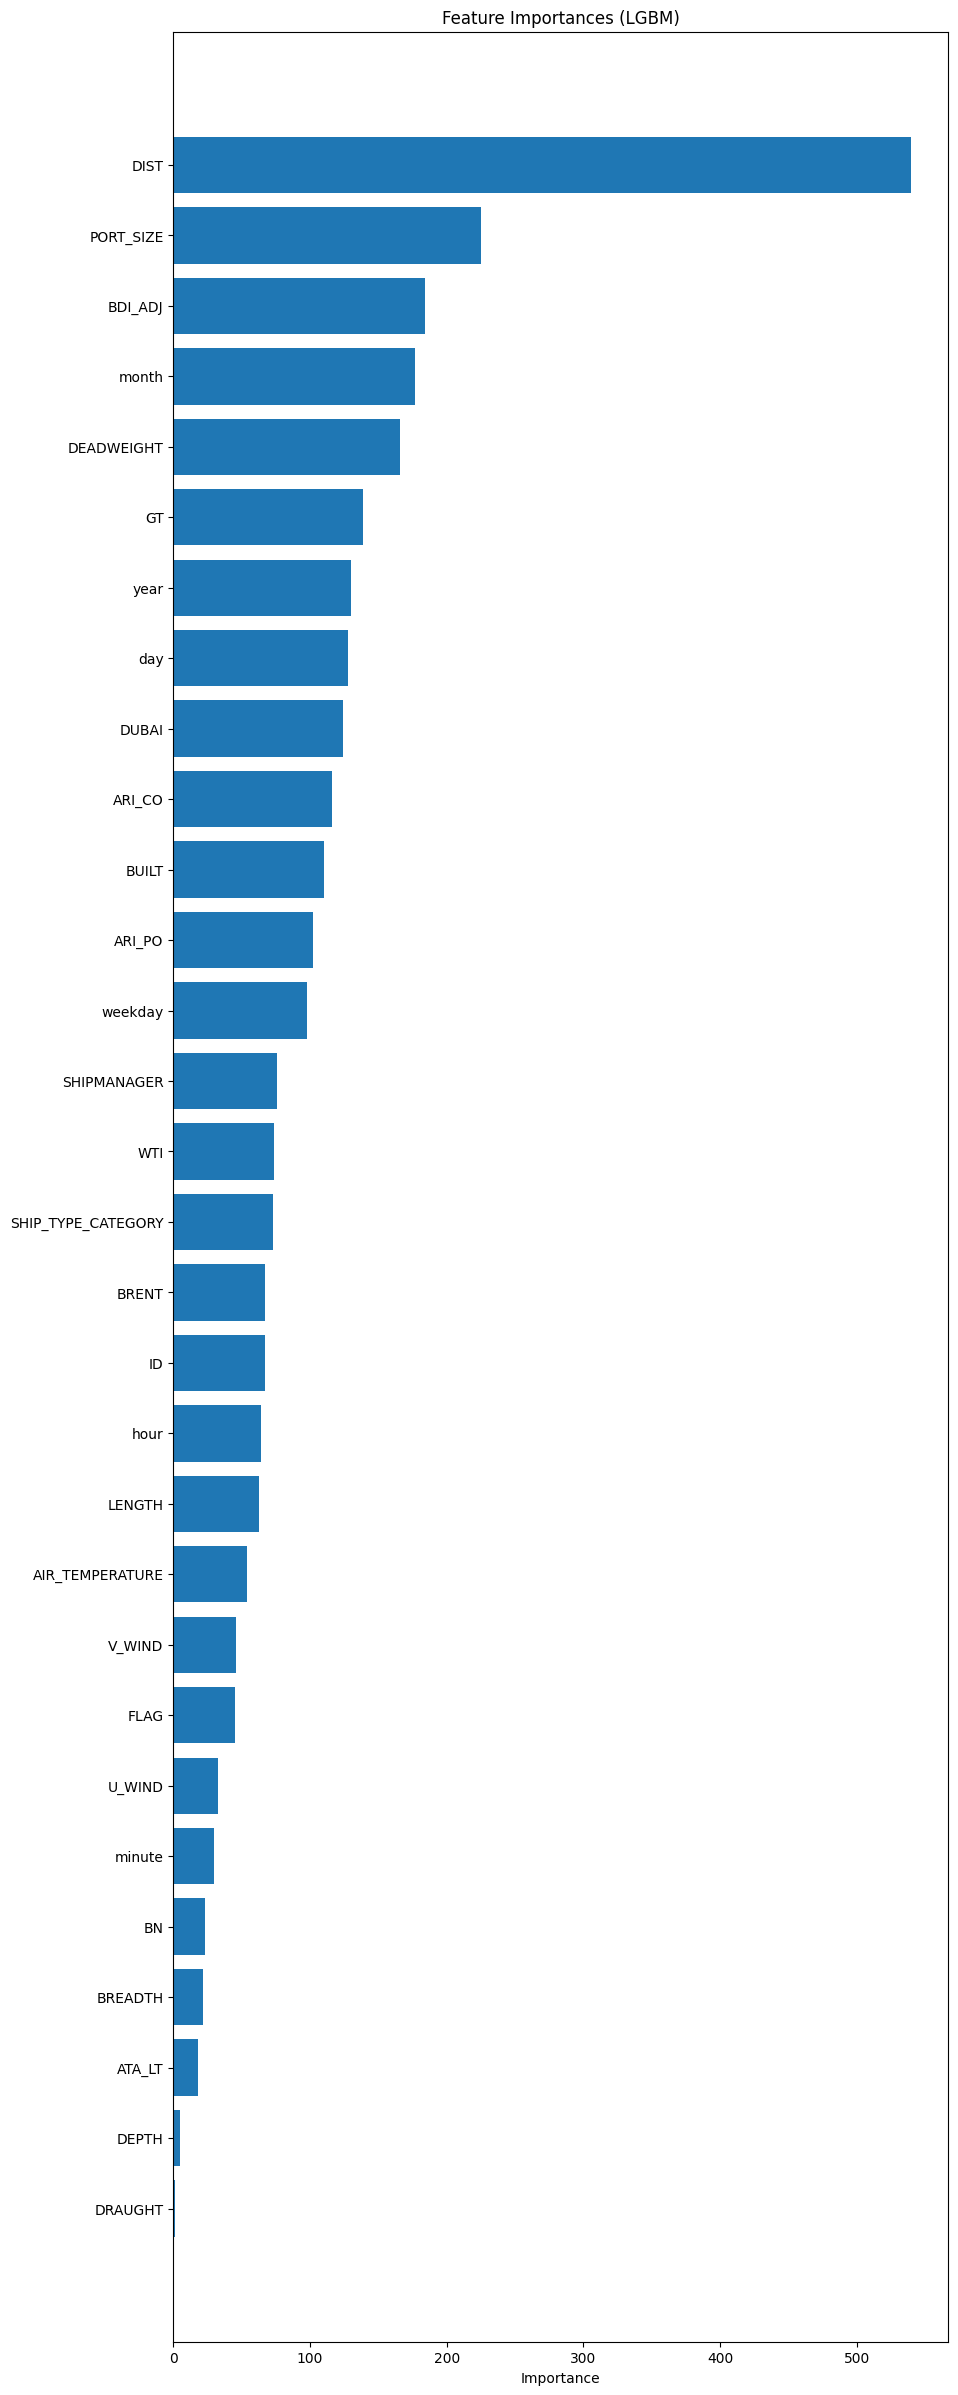

In [16]:
def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)
    
    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()
    
    return model, feature_importances

X_train = train.drop(columns='CI_HOUR')
y_train = train['CI_HOUR']

X_dev = val_df.drop(columns='CI_HOUR')
y_dev = val_df['CI_HOUR']

# Model Tune for LGBM
lgbm_model, lgbm_feature_importances = train_and_evaluate(lgb.LGBMRegressor(), 'LGBM', X_train, y_train)

# 특성 중요도로부터 Feature Selection

In [17]:
threshold = 85 # Your Threshold
low_importance_features = X_train.columns[lgbm_feature_importances < threshold]

X_train_reduced = X_train.drop(columns=low_importance_features)
X_dev_reduced = X_dev.drop(columns=low_importance_features)
X_test_reduced = test.drop(columns=low_importance_features)

# K-Fold Model Fitting & Validation

In [19]:
lgbm = lgb.LGBMRegressor(n_estimators=20000)

# 5-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
ensemble_dev_predictions = []
scores = []

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=5, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]
    
    # 두 모델 모두 학습
    lgbm.fit(X_t, y_t)
    
    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = lgbm.predict(X_val)
    
    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(y_val, val_pred))
    
    # test 데이터셋에 대한 예측 수행 후 저장
    lgbm_pred = lgbm.predict(X_test_reduced)
    lgbm_pred = np.where(lgbm_pred < 0, 0, lgbm_pred)
    
    ensemble_predictions.append(lgbm_pred)
    
    dev_lgbm_pred = lgbm.predict(X_dev_reduced)
    dev_lgbm_pred = np.where(dev_lgbm_pred < 0, 0, dev_lgbm_pred)
    
    ensemble_predictions.append(lgbm_pred)
    ensemble_dev_predictions.append(dev_lgbm_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)
dev_final_predictions = np.mean(ensemble_dev_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

Processing folds:   0%|                                                                          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1619
[LightGBM] [Info] Number of data points in the train set: 235162, number of used features: 13
[LightGBM] [Info] Start training from score 63.456564


Processing folds:  20%|█████████████                                                    | 1/5 [01:50<07:22, 110.56s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001921 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1618
[LightGBM] [Info] Number of data points in the train set: 235162, number of used features: 13
[LightGBM] [Info] Start training from score 63.553861


Processing folds:  40%|██████████████████████████                                       | 2/5 [03:34<05:19, 106.43s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1620
[LightGBM] [Info] Number of data points in the train set: 235162, number of used features: 13
[LightGBM] [Info] Start training from score 63.314376


Processing folds:  60%|███████████████████████████████████████                          | 3/5 [05:18<03:31, 105.55s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1619
[LightGBM] [Info] Number of data points in the train set: 235163, number of used features: 13
[LightGBM] [Info] Start training from score 63.432767


Processing folds:  80%|████████████████████████████████████████████████████             | 4/5 [07:03<01:45, 105.29s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001897 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1619
[LightGBM] [Info] Number of data points in the train set: 235163, number of used features: 13
[LightGBM] [Info] Start training from score 63.101040


Processing folds: 100%|█████████████████████████████████████████████████████████████████| 5/5 [08:48<00:00, 105.79s/it]

Validation : MAE scores for each fold: [25.387135289386066, 25.210707851099382, 26.066531074982798, 25.650499152792694, 25.492071598087282]
Validation : MAE: 25.561388993269645


# Validation

In [20]:
mean_absolute_error(y_dev, dev_final_predictions)

25.613723922931698

# Submission

In [22]:
submit = pd.read_csv('../open/sample_submission.csv')
submit['CI_HOUR'] = final_predictions
submit.to_csv('../Sub/baseline_submit_epoch20000_2.csv', index=False)